In [ ]:
import librosa
import numpy as np
import torch
import matplotlib.pyplot as plt
import soundfile as sf

from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC

audio_path = "/content/LJ037-0171.wav"
audio, sr = librosa.load(audio_path, sr=None, mono=True)

# Resample to 16kHz if needed
target_sr = 16000
if sr != target_sr:
    audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)
    sr = target_sr


In [ ]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
inputs = processor(audio, sampling_rate=sr, return_tensors="pt", padding=True)

with torch.no_grad():
    logits = model(inputs.input_values).logits

predicted_ids = torch.argmax(logits, dim=-1)
tokens = processor.tokenizer.convert_ids_to_tokens(predicted_ids[0])


In [ ]:
time_per_step = audio.shape[0] / logits.shape[1] / sr

phonemes = []
start = 0
prev = tokens[0]

for i, tok in enumerate(tokens):
    if tok != prev:
        end = i
        if prev != "|":  # ignore silence token
            phonemes.append((prev, start * time_per_step, end * time_per_step))
        start = i
        prev = tok

# Add last phoneme
end = len(tokens)
if prev != "|":
    phonemes.append((prev, start * time_per_step, end * time_per_step))



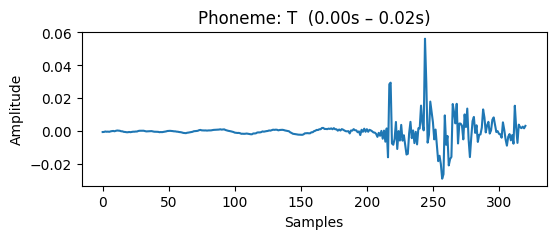

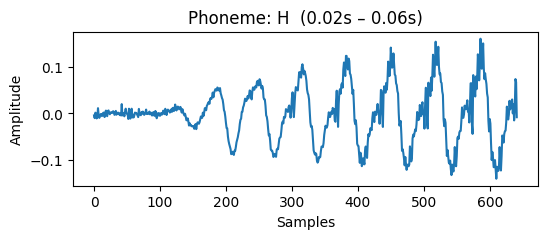

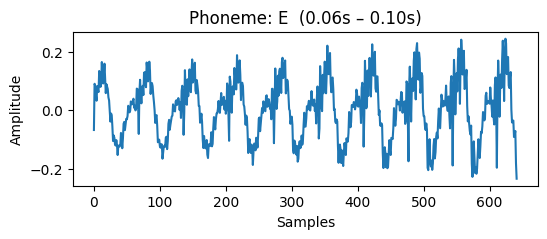

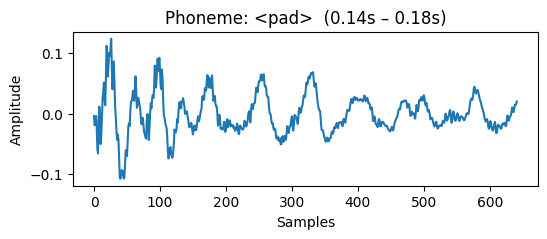

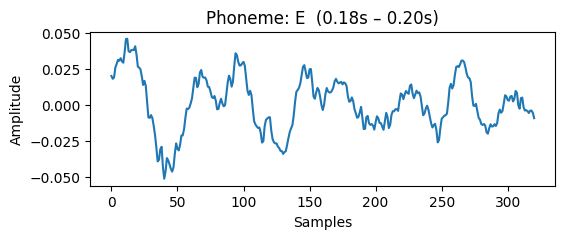

In [ ]:
output_segments = []

for idx, (ph, t_start, t_end) in enumerate(phonemes[:5]):  # first 5 phonemes
    s = int(t_start * sr)
    e = int(t_end * sr)
    segment = audio[s:e]

    # Save phoneme audio
    out_path = f"phoneme_{idx}_{ph}.wav"
    sf.write(out_path, segment, sr)
    output_segments.append(out_path)

    # Visualize waveform
    plt.figure(figsize=(6, 2))
    plt.plot(segment)
    plt.title(f"Phoneme: {ph}  ({t_start:.2f}s – {t_end:.2f}s)")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.show()


In [ ]:
def infer_source(phoneme):
    if phoneme in ["P", "B", "T", "D", "K", "G"]:
        return "Plosive (burst of air, vocal tract closure)"
    elif phoneme in ["S", "Z", "F", "V", "SH"]:
        return "Fricative (turbulent airflow)"
    elif phoneme in ["M", "N", "NG"]:
        return "Nasal (airflow through nasal cavity)"
    elif phoneme in ["AA", "AE", "AH", "EH", "IH", "IY", "OW", "UH", "UW"]:
        return "Vowel (voiced, open vocal tract)"
    else:
        return "Other / approximant sound"

for ph, t1, t2 in phonemes[:5]:
    print(f"Phoneme: {ph}, Source: {infer_source(ph)}")

Phoneme: T, Source: Plosive (burst of air, vocal tract closure)
Phoneme: H, Source: Other / approximant sound
Phoneme: E, Source: Other / approximant sound
Phoneme: <pad>, Source: Other / approximant sound
Phoneme: E, Source: Other / approximant sound
